# BLAES Units Group Analyses

This notebook contains code for running group-level analyses for the BLAES Units project.

---

> *Contact: Justin Campbell (justin.campbell@hsc.utah.edu)*  
> *Version: 10/18/2024*

## 1. Import Libraries

In [1]:
import os
import re
import glob
import datetime
import numpy as np
import pandas as pd
from scipy.stats import wilcoxon, ranksums, ttest_rel, chi2_contingency, ks_2samp, norm, friedmanchisquare, mannwhitneyu, fisher_exact
from matplotlib_venn import venn2, venn2_circles, venn3, venn3_circles
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerBase
from matplotlib.colors import ListedColormap
import warnings

## 2. Define Paths & Parameters

In [2]:
# Define path
projDir = '/Users/justincampbell/Library/CloudStorage/GoogleDrive-u0815766@gcloud.utah.edu/My Drive/Research Projects/BLAESUnits/'
resultsDir = os.path.join(projDir, 'Results')

# Flag for whether to save results & figures
export = True

# Flag for whether to recompute stats (True) or load from file (False)
recomputeStats = False

# Pre-stim firing rate threshold (Hz)
fr_thresh = 0.1

# Display params
%matplotlib inline
%config InlineBackend.figure_format='retina'
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings('ignore')

## 3. Unit & Spike Metrics
Use the information defined in `Events.csv` and `PSEpochs.csv` to tabulate the spike counts; separated into 1s epochs (pre ISI, image onset, during-stim, post-stim). Also save basic unit descriptives (i.e., counts by region).

### 3.1 Spikes Per Trial
Exported as: `TrialSpikeCounts.csv`.

In [3]:
def createSpikeDF(pID):
    '''
    This function takes in a pID and returns a DataFrame with spike counts for each unit in each epoch of each trial.

    Inputs:
    pID (str): The participant ID
    condition (str): The condition to analyze ('Stim' or 'No-Stim')
    
    Outputs:
    spikesDF (DataFrame): A DataFrame with spike counts.
    '''

    # Recording fs
    fs = 30000
    
    # Load events and PSEpochs
    events = pd.read_csv(os.path.join(resultsDir, pID, 'Events.csv'), index_col = 0)
    PSEpochs_stim = pd.read_csv(os.path.join(resultsDir, pID, 'StimEpochs.csv'), index_col = 0)
    PSEpochs_nostim = pd.read_csv(os.path.join(resultsDir, pID, 'NoStimEpochs.csv'), index_col = 0)
    
    # Combine epochs
    PSEpochs = pd.concat([PSEpochs_stim, PSEpochs_nostim], axis = 1)
    PSEpochs.columns = np.arange(PSEpochs.shape[1])
    PSEpochs = PSEpochs.reset_index(drop = True)
    epochsID = np.zeros(PSEpochs.shape[1])
    epochsID[:PSEpochs_stim.shape[1]] = 1
    epochsID = np.where(epochsID == 1, 'Stim', 'No-Stim')

    # Sort based on start time
    sorted_idx = PSEpochs.loc[0,:].sort_values().index
    PSEpochs = PSEpochs[sorted_idx]
    epochsID = epochsID[sorted_idx]

    # Loop through channels
    spikeDFHolder = []
    for chan in events['Channel'].unique():
        chanDF = events[events['Channel'] == chan]
        # Loop through units
        for unit in chanDF['Unit'].unique():
            unitDF = chanDF[chanDF['Unit'] == unit]
            unitSpikes = unitDF['TimeStamps']
            
            # Initialize spike count dictionaries
            preISISpikes = {}
            imgOnsetSpikes = {}
            preSpikes = {}
            duringSpikes = {}
            postSpikes = {}
            
            # Loop through epochs/trials
            for epoch in range(PSEpochs.shape[1]):
                epochStart = PSEpochs.iloc[0, epoch]
                epochImgOnset = epochStart + fs
                epochStimOnset = epochStart + (4 * fs)
                epochStimOffset = PSEpochs.iloc[-1, epoch] - fs
                epochEnd = PSEpochs.iloc[-1, epoch]
                
                # Epoch spikes
                epochSpikes = unitSpikes[(unitSpikes > epochStart) & (unitSpikes < epochEnd)]
                
                # Initialize spike count variables
                preISICount = 0
                imgOnsetCount = 0
                preCount = 0
                duringCount = 0
                postCount = 0
                
                for spike in epochSpikes:
                    if spike < epochImgOnset:
                        preISICount += 1
                    elif spike >= epochImgOnset and spike < (epochImgOnset + fs):
                        imgOnsetCount += 1
                    elif spike >= (epochStimOnset - fs) and spike < epochStimOnset:
                        preCount += 1
                    elif spike >= epochStimOnset and spike < epochStimOffset:
                        duringCount += 1
                    elif spike >= epochStimOffset:
                        postCount += 1
                            
                # Update dictionaries
                preISISpikes[epoch] = preISICount
                imgOnsetSpikes[epoch] = imgOnsetCount
                preSpikes[epoch] = preCount
                duringSpikes[epoch] = duringCount
                postSpikes[epoch] = postCount
                
            # Convert to DataFrame
            unitSpikeDF = pd.DataFrame([preISISpikes, imgOnsetSpikes, preSpikes, duringSpikes, postSpikes]).T
            unitSpikeDF.columns = ['ISI', 'ImgOnset', 'Pre', 'During', 'Post']
            unitSpikeDF['Trial'] = np.arange(1, unitSpikeDF.shape[0] + 1)
            unitSpikeDF['Unit'] = chan + '-' + str(unit)
            unitSpikeDF['pID'] = pID
            unitSpikeDF['Condition'] = epochsID
            
            # Validity check
            # if unitSpikeDF['Pre'].sum() >= 5 and unitSpikeDF['During'].sum() >= 5 and unitSpikeDF['Post'].sum() >= 5:
            if unitSpikeDF['ISI'].mean(skipna = True) >= fr_thresh:
                unitSpikeDF['Valid'] = True
            else:
                unitSpikeDF['Valid'] = False
                
            # Append to list
            spikeDFHolder.append(unitSpikeDF)

    spikesDF = pd.concat(spikeDFHolder)
    spikesDF = spikesDF.reset_index(drop = True)
    
    return spikesDF

In [4]:
# Find every folder in resultsDir that is not labeled "Group"
pIDs = [x for x in os.listdir(resultsDir) if os.path.isdir(os.path.join(resultsDir, x)) and x != 'Group']

# Loop through pIDs
holder = []
for pID in pIDs:
    spikesDF = createSpikeDF(pID)
    spikesDF.to_csv(os.path.join(resultsDir, pID, 'TrialSpikeCounts.csv'))
    holder.append(spikesDF)
        
# Combine into one DataFrame
allSpikes = pd.concat(holder)

In [5]:
# Get the average spike counts
avgSpikes = allSpikes.groupby(['pID', 'Unit', 'Condition']).mean()
avgSpikes.drop(columns = 'Trial', inplace = True)

### 3.2 Remove/Exclude Flagged Units

In [6]:
# Load existing (manually defined)
unitsToExclude = pd.read_csv('/Users/justincampbell/Library/CloudStorage/GoogleDrive-u0815766@gcloud.utah.edu/My Drive/Research Projects/BLAESUnits/UnitsToExclude.csv')

# remove rows from allSpikes that match the pID and Unit in unitsToExclude
for index, row in unitsToExclude.iterrows():
    allSpikes = allSpikes[~((allSpikes['pID'] == row['pID']) & (allSpikes['Unit'] == row['Unit']))]

### 3.3 Organize Spike Info Into Group Dataset
Exported as `AllSpikeInfo.csv`.

In [7]:
# Load the stim info
stimInfo = pd.read_csv('/Users/justincampbell/Library/CloudStorage/GoogleDrive-u0815766@gcloud.utah.edu/My Drive/Research Projects/BLAESUnits/BLAESUnits Stim.csv')
stimInfo = stimInfo[stimInfo['Included'] == 1]

# Add the stim info laterality to the validUnits DataFrame
allSpikeInfo = allSpikes.merge(stimInfo[['pID', 'Laterality']], on = 'pID', how = 'left')
allSpikeInfo.rename(columns = {'Laterality': 'StimLat'}, inplace = True)

# Determine unit laterality from the unit name
allSpikeInfo['UnitLat'] = [x[1] for x in allSpikeInfo['Unit'].str.split('-').str[0]]

# Designate ipsilateral and contralateral units
allSpikeInfo['Ipsilateral'] = allSpikeInfo['StimLat'] == allSpikeInfo['UnitLat']

# Add region labels
regionDict = {'CV': 'ACC', 'HIP': 'HIP', 'ACC': 'ACC', 'CD': 'ACC', 'OFC': 'OFC',
            'VCG': 'ACC', 'AHIP': 'HIP', 'HC': 'HIP', 'HCA': 'HIP', 'DAC': 'ACC', 
            'DCG': 'ACC', 'AMY': 'AMY', 'FUG': 'FUG'}
allSpikeInfo['Region'] = pd.Series([x.split('-')[0][2:-1] for x in allSpikeInfo['Unit']]).map(regionDict)

# Export
if export:
    allSpikeInfo.to_csv(os.path.join(resultsDir, 'Group', 'AllSpikeInfo.csv'))

### 3.4 Descriptives
Exported as: `UnitDescriptives.txt`.

In [8]:
def summarizeData():
    '''
    Print summary of data.
    '''
    
    # Display group summary
    print('Sessions: %s ' %len(pIDs), pIDs)
    print('')
    print('Leads: %i (Wires: %i)' %(stimInfo['Leads'].sum(), stimInfo['Leads'].sum()*8))
    print('')
    print('Units Flagged for Exclusion: %i' %unitsToExclude.shape[0])
    print('')
    print(allSpikeInfo.groupby(['pID', 'Unit'])['Region'].first().value_counts().to_string())
    print('')
    print('Processed: ' + str(datetime.datetime.now()))

In [9]:
%%capture cap
summarizeData()

In [10]:
# Save descriptives
if export:
    with open((os.path.join(resultsDir, 'Group', 'UnitDescriptives.txt')), 'w') as f:
        f.write(str(cap))
        
# Show descriptives
summarizeData()

Sessions: 30  ['BJH02702', 'BJH02501', 'UIC20221301', 'BJH02703', 'UIC20221701', 'BJH04001', 'UIC20230701', 'BJH03501', 'BJH02402', 'BJH04502', 'BJH02601', 'UIC20231401', 'BJH04901', 'BJH03201', 'BJH02701', 'UIC20231101', 'BJH02502', 'BJH04601', 'BJH02901', 'BJH04201', 'UIC20240101', 'UIC20221501', 'BJH02503', 'BJH03301', 'BJH02401', 'BJH04501', 'BJH02602', 'UIC20230601', 'UIC20230201', 'UIC20230801']

Leads: 68 (Wires: 544)

Units Flagged for Exclusion: 7

Region
HIP    95
OFC    44
AMY    39
ACC    25

Processed: 2025-05-22 09:32:24.816457


## 4. Firing-Rate Modulation Analyses

### 4.1 Pre- vs. Post-Stim & Pre- vs. During-Stim Spike Counts
Paired test comparing in three conrasts: ISI vs. Image Onset, ISI vs. During-Stim, ISI vs. Post-Stim followed by permutation testing (1,000x) to determine significance.

In [11]:
def runFRContrast():
    '''
    This function runs a Wilcoxon signed-rank test on the firing rates of each unit in three contrasts: ISI vs. Img Onset, ISI vs. During-Stim, and ISI vs. Post-Stim. It also runs permutation testing to determine whether the observed test statistic is in the 5% of most extreme values in the permutation distribution (p < 0.05).
    
    Inputs:
    - None
    
    Outputs:
    - statsDF (DataFrame): A DataFrame with the results of the statistical tests.
    '''
    
    # Holders for unit characteristics
    unitLabels = []
    pIDLabels = []
    validity = []
    laterality = []
    regions = []
    FR_ISI = []
    FR_stim_ISI = []
    FR_nostim_ISI = []
    FR_Img = []
    FR_stim_During = []
    FR_nostim_During = []
    FR_stim_Post = []
    FR_nostim_Post = []
    
    # Holders for empirical Wilcoxon stat
    stat_Img = []
    stat_stim_During = []
    stat_nostim_During = []
    stat_stim_Post = []
    stat_nostim_Post = []
    
    # Holders for empirical Wilcoxon p-value
    p_Img = []
    p_stim_During = []
    p_nostim_During = []
    p_stim_Post = []
    p_nostim_Post = []
    
    # Holders for distribution of permuted Wilcoxon stats
    statPerm_Img = []
    statPerm_stim_During = []
    statPerm_nostim_During = []
    statPerm_stim_Post = []
    statPerm_nostim_Post = []
    
    # Holders for p-value derived from permutation testing
    pPerm_Img = []
    pPerm_stim_During = []
    pPerm_nostim_During = []
    pPerm_stim_Post = []
    pPerm_nostim_Post = []

    # Holders for significance testing (True if p < 0.05)
    res_Img = []
    res_stim_During = []
    res_nostim_During = []
    res_stim_Post = []
    res_nostim_Post = []
    
    # Permutation params
    nPerms = 1000
    np.random.seed(0)
    
    # Loop through each session
    for pID in allSpikeInfo['pID'].unique():
        pIDSpikes = allSpikeInfo[allSpikeInfo['pID'] == pID]
        
        # Loop through each unit
        for unit in pIDSpikes['Unit'].unique():
            unitDF = pIDSpikes[pIDSpikes['Unit'] == unit]
            
            # Loop through contrasts
            for i in range(5):
                # Determine condition
                if i == 0:
                    condition = 'Both'
                    contrastDF = unitDF.copy()
                elif (i == 1) or (i == 3):
                    condition = 'Stim'
                    contrastDF = unitDF[unitDF['Condition'] == 'Stim'].copy()
                elif (i == 2) or (i == 4):
                    condition = 'No-Stim'
                    contrastDF = unitDF[unitDF['Condition'] == 'No-Stim'].copy()
                    
                # Determine contrast
                if i == 0:
                    contrast = 'ImgOnset'
                elif (i == 1) or (i == 2):
                    contrast = 'During'
                elif (i == 3) or (i == 4):
                    contrast = 'Post'
            
                # Run stats on valid units
                if contrastDF['Valid'].iloc[0] == True:
                    try:
                        stat, p = wilcoxon(contrastDF[contrast], contrastDF['ISI'])
                    except:
                        stat = np.nan
                        p = np.nan
                        
                    # Permutation testing
                    statPerms = []
                    for i in range(nPerms):
                        permDF = contrastDF[['ISI', contrast]].copy().melt(var_name = 'Epoch', value_name = 'Spike')
                        epochLabels = permDF['Epoch']
                        epochLabels = np.random.permutation(epochLabels)
                        permDF['Epoch'] = epochLabels
                        isiSpikes = permDF[permDF['Epoch'] == 'ISI']['Spike']
                        contrastSpikes = permDF[permDF['Epoch'] == contrast]['Spike']
                        statPerm, _ = wilcoxon(contrastSpikes.values, isiSpikes.values)
                        statPerms.append(statPerm)
                        
                    # Compute p-values using z-score method(from permutation distribution)
                    zContrast = (stat - np.mean(statPerms)) / np.std(statPerms)
                    pPerm = norm.sf(abs(zContrast)) * 2
                    if pPerm < 0.05:
                        resPerm = True
                    else:
                        resPerm = False
                        
                # If unit is invalid         
                else:
                    stat = np.nan
                    p = np.nan
                    pPerm = np.nan
                    resPerm = np.nan
                    statPerms = np.nan
                    
                # Append contrast statistics
                if contrast == 'ImgOnset':
                    stat_Img.append(stat)
                    p_Img.append(p)
                    statPerm_Img.append(statPerms)
                    pPerm_Img.append(pPerm)
                    res_Img.append(resPerm)
                elif (condition == 'Stim') and (contrast == 'During'):
                    stat_stim_During.append(stat)
                    p_stim_During.append(p)
                    statPerm_stim_During.append(statPerms)
                    pPerm_stim_During.append(pPerm)
                    res_stim_During.append(resPerm)
                elif (condition == 'No-Stim') and (contrast == 'During'):
                    stat_nostim_During.append(stat)
                    p_nostim_During.append(p)
                    statPerm_nostim_During.append(statPerms)
                    pPerm_nostim_During.append(pPerm)
                    res_nostim_During.append(resPerm)
                elif (condition == 'Stim') and (contrast == 'Post'):
                    stat_stim_Post.append(stat)
                    p_stim_Post.append(p)
                    statPerm_stim_Post.append(statPerms)
                    pPerm_stim_Post.append(pPerm)
                    res_stim_Post.append(resPerm)
                elif (condition == 'No-Stim') and (contrast == 'Post'):
                    stat_nostim_Post.append(stat)
                    p_nostim_Post.append(p)
                    statPerm_nostim_Post.append(statPerms)
                    pPerm_nostim_Post.append(pPerm)
                    res_nostim_Post.append(resPerm)
                
            # Append unit characteristics
            unitLabels.append(unit)
            pIDLabels.append(pID)
            validity.append(unitDF['Valid'].iloc[0])
            laterality.append(unitDF['Ipsilateral'].iloc[0])
            regions.append(unitDF['Region'].iloc[0])
            FR_ISI.append(unitDF['ISI'].mean())
            FR_stim_ISI.append(unitDF[unitDF['Condition'] == 'Stim']['ISI'].mean())
            FR_nostim_ISI.append(unitDF[unitDF['Condition'] == 'No-Stim']['ISI'].mean())
            FR_Img.append(unitDF['ImgOnset'].mean())
            FR_stim_During.append(unitDF[unitDF['Condition'] == 'Stim']['During'].mean())
            FR_nostim_During.append(unitDF[unitDF['Condition'] == 'No-Stim']['During'].mean())
            FR_stim_Post.append(unitDF[unitDF['Condition'] == 'Stim']['Post'].mean())
            FR_nostim_Post.append(unitDF[unitDF['Condition'] == 'No-Stim']['Post'].mean())
            
    # Construct dataframe
    statsDF = pd.DataFrame({'pID': pIDLabels, 
                            'Unit': unitLabels, 
                            'Region': regions, 
                            'Ipsilateral': laterality, 
                            'Valid': validity, 
                            'FR_ISI': FR_ISI, 
                            'FR_Stim_ISI': FR_stim_ISI,
                            'FR_NoStim_ISI': FR_nostim_ISI,
                            'FR_Img': FR_Img, 
                            'FR_Stim_During': FR_stim_During, 
                            'FR_NoStim_During': FR_nostim_During, 
                            'FR_Stim_Post': FR_stim_Post, 
                            'FR_NoStim_Post': FR_nostim_Post, 
                            'Stat_Img': stat_Img, 
                            'Stat_Stim_During': stat_stim_During, 
                            'Stat_NoStim_During': stat_nostim_During,  
                            'Stat_Stim_Post': stat_stim_Post, 
                            'Stat_NoStim_Post': stat_nostim_Post,
                            'p_Img': p_Img,
                            'p_Stim_During': p_stim_During, 
                            'p_NoStim_During': p_nostim_During,
                            'p_Stim_Post': p_stim_Post, 
                            'p_NoStim_Post': p_nostim_Post,
                            'StatPerm_Img': statPerm_Img, 
                            'StatPerm_Stim_During': statPerm_stim_During, 
                            'StatPerm_NoStim_During': statPerm_nostim_During,
                            'StatPerm_Stim_Post': statPerm_stim_Post, 
                            'StatPerm_NoStim_Post': statPerm_nostim_Post,
                            'pPerm_Img': pPerm_Img, 
                            'pPerm_Stim_During': pPerm_stim_During, 
                            'pPerm_NoStim_During': pPerm_nostim_During,
                            'pPerm_Stim_Post': pPerm_stim_Post, 
                            'pPerm_NoStim_Post': pPerm_nostim_Post,
                            'SigPerm_Img': res_Img, 
                            'SigPerm_Stim_During': res_stim_During, 
                            'SigPerm_NoStim_During': res_nostim_During,
                            'SigPerm_Stim_Post': res_stim_Post, 
                            'SigPerm_NoStim_Post': res_nostim_Post})

    # Add column for significant results w/ permutation testing
    statsDF['StimSig'] = (statsDF['SigPerm_Stim_During'] == True) | (statsDF['SigPerm_Stim_Post'] == True)
    statsDF['NoStimSig'] = (statsDF['SigPerm_NoStim_During'] == True) | (statsDF['SigPerm_NoStim_Post'] == True)
    statsDF['ImgSig'] = (statsDF['SigPerm_Img'] == True)
    
    # Export
    statsDF.to_csv(os.path.join(resultsDir, 'Group', 'SpikeStats.csv'))
    
    return statsDF

In [12]:
# Recompute or load stats
if recomputeStats:
    statsDF = runFRContrast()
else:
    statsDF = pd.read_csv(os.path.join(resultsDir, 'Group', 'SpikeStats.csv'), index_col = 0)

### 4.2 Distance Analysis
Compute the pairwise Euclidean distance between the stim contacts (bipolar midpoint), and the average unit location.

In [13]:
def createElecDF(pID):
    '''
    Create a DataFrame with electrode information for a given participant ID.
    
    Input:
    - pID (str): Participant ID

    Output:
    - pIDElecDF (DataFrame): DataFrame with electrode information
    '''
    
    try:
        # Get stimInfo and elecInfo for pID
        pIDStimInfo = stimInfo[stimInfo['pID'].str.contains(pID)].copy()
        pIDElecInfo = elecInfo[elecInfo['pID'].str.contains(pID[0:-2])].copy()

        # Parse elecInfo for stim contacts
        cathodesDF = pIDElecInfo[pIDElecInfo['Channel'].isin(pIDStimInfo['Cathode'])].sort_values('Channel')
        anodesDF = pIDElecInfo[pIDElecInfo['Channel'].isin(pIDStimInfo['Anode'])].sort_values('Channel')
        cathodes = cathodesDF['Channel'].values
        anodes = anodesDF['Channel'].values

        # Get MNI coordinates for bipolar pair
        MNI_Xs = (np.array(cathodesDF['MNI_X']) + np.array(anodesDF['MNI_X'])) / 2
        MNI_Ys = (np.array(cathodesDF['MNI_Y']) + np.array(anodesDF['MNI_Y'])) / 2
        MNI_Zs = (np.array(cathodesDF['MNI_Z']) + np.array(anodesDF['MNI_Z'])) / 2

        # Contruct DF for stim electrodes
        stimElecDF = pd.DataFrame({'Cathode': cathodes, 'Anode': anodes, 'MNI_X': MNI_Xs, 'MNI_Y': MNI_Ys, 'MNI_Z': MNI_Zs, 'Stim': True})
        stimElecDF = stimElecDF.merge(pIDStimInfo[['Cathode', 'Anode', 'pID']], on = ['Cathode', 'Anode'], how = 'left')
        stimElecDF['Channel'] = stimElecDF['Cathode'] + '-' + stimElecDF['Anode']
        stimElecDF.drop(columns = ['Cathode', 'Anode'], inplace = True)

        # Get unique leads from micro channel labels
        microLeads = list(set(x[0:-1] for x in pIDElecInfo[pIDElecInfo['Channel'].str.contains('m')]['Channel']))
        microElecDF = []
        for micro in microLeads:    
            microElecInfo = pIDElecInfo[pIDElecInfo['Channel'].str.contains(micro)].copy()
            # Assign the average MNI coordinates to each contact
            microElecInfo['MNI_X'] = microElecInfo['MNI_X'].copy().mean()
            microElecInfo['MNI_Y'] = microElecInfo['MNI_Y'].copy().mean()
            microElecInfo['MNI_Z'] = microElecInfo['MNI_Z'].copy().mean()
            # Add additional info
            microElecInfo['Stim'] = False
            microElecInfo['pID'] = pID
            microElecDF.append(microElecInfo[['MNI_X', 'MNI_Y', 'MNI_Z', 'Stim', 'pID', 'Channel']])
        microElecDF = pd.concat(microElecDF)
    
        # Concatenate stim and micro electrode dataframes
        pIDElecDF = pd.concat([stimElecDF, microElecDF])
        
        return pIDElecDF
    
    except:
        print('Could not process ' + pID)
        return None

In [14]:
# Get ElecInfo.csv files
elecInfoFiles = glob.glob('/Users/justincampbell/Library/CloudStorage/GoogleDrive-u0815766@gcloud.utah.edu/My Drive/Research Projects/BLAESUnits/ElectrodeInfo/*ElectrodeInfo.csv')

# Load and concatenate ElectrodeInfo files
elecInfo = []
for file in elecInfoFiles:
    elecDF = pd.read_csv(file)
    elecDF['pID'] = file.split('/')[-1].split('_')[0]
    elecInfo.append(elecDF)
elecInfo = pd.concat(elecInfo)

# Rename chanLabel column
elecInfo.rename(columns = {'chanLabel': 'Channel'}, inplace = True)

In [15]:
# Get electrode information for each participant
allElecsDF = []
for pID in pIDs:
    pIDElecDF = createElecDF(pID)
    allElecsDF.append(pIDElecDF)
allElecsDF = pd.concat(allElecsDF)
allElecsDF = allElecsDF.reset_index(drop = True)

In [16]:
if recomputeStats:

    # Combine XYZ info with statsDF
    statsDF['Channel'] = statsDF['Unit'].str.split('-').str[0]
    statsDF = statsDF.merge(allElecsDF[['pID', 'Channel', 'MNI_X', 'MNI_Y', 'MNI_Z']], on = ['pID', 'Channel'], how = 'left')

    # WashU fix (need to map WashU labels e.g., GR3 to new labels e.g., mRHIP3)
    washUMicroMap = pd.read_csv('/Users/justincampbell/Library/CloudStorage/GoogleDrive-u0815766@gcloud.utah.edu/My Drive/Research Projects/BLAESUnits/WashU Micro Labels.csv')
    for pID in washUMicroMap['pID'].unique():
        pIDdf = washUMicroMap[washUMicroMap['pID'] == pID]
        for lead in washUMicroMap[washUMicroMap['pID'] == pID]['Lead'].unique():
            pIDLeadDF = pIDdf[pIDdf['Lead'] == lead]
            label = pIDLeadDF['Label'].values[0]
            for i in range(1,9):
                channelOrig = lead + str(i)
                channelNew = label + str(i)
                MNI_X = allElecsDF[(allElecsDF['pID'].str.contains(pID)) & (allElecsDF['Channel'] == channelOrig)]['MNI_X'].mean()
                MNI_Y = allElecsDF[(allElecsDF['pID'].str.contains(pID)) & (allElecsDF['Channel'] == channelOrig)]['MNI_Y'].mean()
                MNI_Z = allElecsDF[(allElecsDF['pID'].str.contains(pID)) & (allElecsDF['Channel'] == channelOrig)]['MNI_Z'].mean()
                statsDF.loc[(statsDF['pID'].str.contains(pID)) & (statsDF['Channel'] == channelNew), 'MNI_X'] = MNI_X
                statsDF.loc[(statsDF['pID'].str.contains(pID)) & (statsDF['Channel'] == channelNew), 'MNI_Y'] = MNI_Y
                statsDF.loc[(statsDF['pID'].str.contains(pID)) & (statsDF['Channel'] == channelNew), 'MNI_Z'] = MNI_Z

    # Get Euclidean distances
    eucDists = []
    for i in range(statsDF.shape[0]):
        pID = statsDF['pID'].iloc[i]
        chan = statsDF['Channel'].iloc[i]
        microXYZ = statsDF[(statsDF['pID'] == pID) & (statsDF['Channel'] == chan)][['MNI_X', 'MNI_Y', 'MNI_Z']].values
        stimChanXYZ = allElecsDF[(allElecsDF['pID'] == pID) & (allElecsDF['Stim'] == True)][['MNI_X', 'MNI_Y', 'MNI_Z']].values
        eucDist = np.linalg.norm(microXYZ - stimChanXYZ, axis = 1)
        # check if eucDist is empty array
        if eucDist.size > 0:
            eucDists.append(eucDist[0])
        else:
            eucDists.append(np.nan)

    # Add to statsDF
    statsDF['EucDist'] = eucDists

### 4.3 Compute Z-scored Firing Rates

In [17]:
if recomputeStats:

    Stim_FR_Img_Z = []
    Stim_FR_During_Z = []
    Stim_FR_Post_Z = []
    NoStim_FR_Img_Z = []
    NoStim_FR_During_Z = []
    NoStim_FR_Post_Z = []

    for i in range(statsDF.shape[0]):
        iDF = statsDF.iloc[i,:]
        pID = iDF['pID']
        unit = iDF['Unit']
        spikeInfo = allSpikeInfo[(allSpikeInfo['pID'] == pID) & (allSpikeInfo['Unit'] == unit)]

        stim_spikeInfo = spikeInfo[spikeInfo['Condition'] == 'Stim']
        stim_image_Z = (stim_spikeInfo['ImgOnset'] - stim_spikeInfo['ISI'].mean()) / stim_spikeInfo['ISI'].std()
        stim_during_Z = (stim_spikeInfo['During'] - stim_spikeInfo['ISI'].mean()) / stim_spikeInfo['ISI'].std()
        stim_post_Z = (stim_spikeInfo['Post'] - stim_spikeInfo['ISI'].mean()) / stim_spikeInfo['ISI'].std()
        Stim_FR_Img_Z.append(stim_image_Z.mean())
        Stim_FR_During_Z.append(stim_during_Z.mean())
        Stim_FR_Post_Z.append(stim_post_Z.mean())
        
        nostim_spikeInfo = spikeInfo[spikeInfo['Condition'] == 'No-Stim']
        nostim_image_Z = (nostim_spikeInfo['ImgOnset'] - nostim_spikeInfo['ISI'].mean()) / nostim_spikeInfo['ISI'].std()
        nostim_during_Z = (nostim_spikeInfo['During'] - nostim_spikeInfo['ISI'].mean()) / nostim_spikeInfo['ISI'].std()
        nostim_post_Z = (nostim_spikeInfo['Post'] - nostim_spikeInfo['ISI'].mean()) / nostim_spikeInfo['ISI'].std()
        NoStim_FR_Img_Z.append(nostim_image_Z.mean())
        NoStim_FR_During_Z.append(nostim_during_Z.mean())
        NoStim_FR_Post_Z.append(nostim_post_Z.mean())
    
    statsDF['Stim_Img_Z'] = Stim_FR_Img_Z
    statsDF['Stim_During_Z'] = Stim_FR_During_Z
    statsDF['Stim_Post_Z'] = Stim_FR_Post_Z
    statsDF['NoStim_Img_Z'] = NoStim_FR_Img_Z
    statsDF['NoStim_During_Z'] = NoStim_FR_During_Z
    statsDF['NoStim_Post_Z'] = NoStim_FR_Post_Z

### 4.4 Save `statsDF`
Exported as: `SpikeStats.csv`.

In [18]:
# Export
if export:
    statsDF.to_csv(os.path.join(resultsDir, 'Group', 'SpikeStats.csv'))

## 5. Figures

Region Palette:


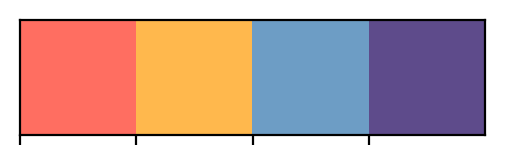

Valid Units Palette:


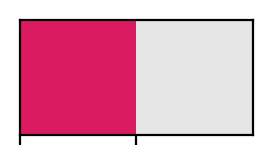

Paired Palette:


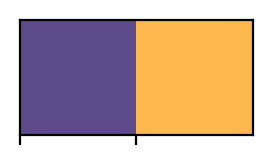

Alternate Paired Palette:


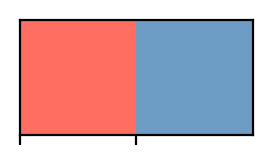

In [19]:
# 90's Anime Color Palette (https://colormagic.app/palette/671d8e4ae9810edeaccc9737)
regionPal = ['#ff6e61', '#ffb84d', '#6d9dc5', '#5e4b8b']
validPal = ['#da1b61', '#e6e6e6']
pairPal = [regionPal[3], regionPal[1]]
altPairPal = [regionPal[0], regionPal[2]]

print('Region Palette:')
sns.palplot(regionPal, size = .75)
plt.show()

print('Valid Units Palette:')
sns.palplot(validPal, size = .75)
plt.show()

print('Paired Palette:')
sns.palplot(pairPal, size = .75)
plt.show()

print('Alternate Paired Palette:')
sns.palplot(altPairPal, size = .75)
plt.show()

In [20]:
class HandlerColormap(HandlerBase):
    def __init__(self, cmap, num_stripes=8, **kw):
        HandlerBase.__init__(self, **kw)
        self.cmap = cmap
        self.num_stripes = num_stripes
    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        stripes = []
        for i in range(self.num_stripes):
            s = Rectangle([xdescent + i * width / self.num_stripes, ydescent], width / self.num_stripes, height, 
                          fc=self.cmap((2 * i + 1) / (2 * self.num_stripes)), transform=trans)
            stripes.append(s)
        return stripes

In [21]:
# Get only valid units for analysis and plotting
statsDFValid = statsDF[statsDF['Valid'] == True]

# sort regionLabels by number of valid units in each region
nRegions = len(statsDFValid['Region'].unique())
plotOrder = statsDF['Region'].value_counts().index
latOrder = [True, False]

# Export colormap
saturation = 0.9
# colorsDF = pd.DataFrame({'Region': plotOrder, 'Color': sns.color_palette('flare', nRegions, desat = saturation).as_hex()})
colorsDF = pd.DataFrame({'Region': plotOrder, 'Color': regionPal})
# colorsDF.to_csv(os.path.join(resultsDir, 'Group', 'RegionColorMap.csv'))

# Preview color palette
print('# Regions = %i' %nRegions)
print(plotOrder.tolist())

# Regions = 4
['HIP', 'OFC', 'AMY', 'ACC']


### 5.1 Unit Summary
Exported as: 
- `UnitsPie.pdf`
- `UnitsPieValid.pdf`
- `ValidUnits.pdf`

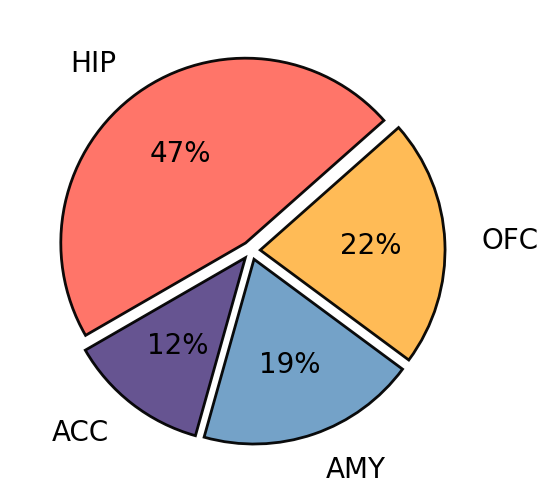

Region
HIP    95
OFC    44
AMY    39
ACC    25


In [22]:
fig, ax = plt.subplots(1, 1, figsize = (3, 3))
plotPal = regionPal

plt.pie(statsDF['Region'].value_counts(), labels = plotOrder, colors = plotPal, counterclock = False, startangle = 210, wedgeprops = {'linewidth': 1, 'edgecolor': 'k', 'alpha': 0.95}, autopct = '%1.f%%', pctdistance= 0.6, labeldistance= 1.2, explode = [0.05] * nRegions)

# Export & Display
if export:
    plt.savefig((os.path.join(resultsDir, 'Group', 'Figures', 'UnitsPie.pdf')), dpi = 1200, bbox_inches = 'tight')
plt.show()

# Show counts
print(statsDF['Region'].value_counts().sort_values(ascending = False).to_string())

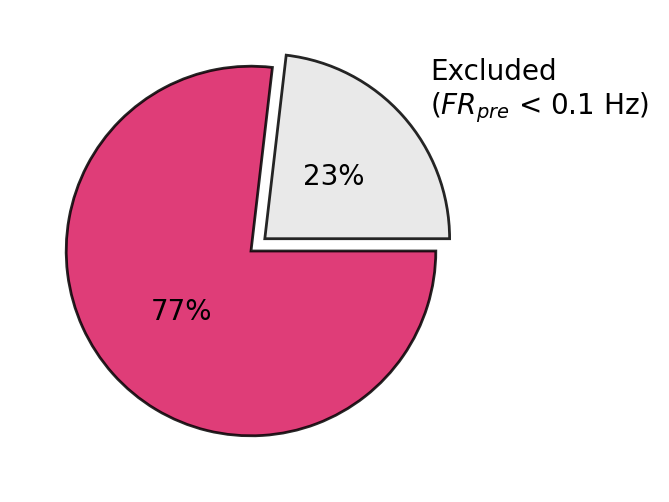

Valid
True     156
False     47


In [23]:
fig, ax = plt.subplots(1, 1, figsize = (3, 3))
plotPal = validPal

plt.pie(statsDF['Valid'].value_counts(), labels = ['', 'Excluded\n($FR_{pre}$ < 0.1 Hz)'], colors = plotPal, counterclock = False, startangle = 360, wedgeprops = {'linewidth': 1, 'edgecolor': 'k', 'alpha': 0.85}, autopct = '%1.f%%', pctdistance= 0.5, labeldistance= 1.2, explode = [0, 0.1])

# Export & Display
if export:
    plt.savefig((os.path.join(resultsDir, 'Group', 'Figures', 'UnitsValidPie.pdf')), dpi = 1200, bbox_inches = 'tight')
plt.show()

# Show counts
print(statsDF['Valid'].value_counts().sort_values(ascending = False).to_string())

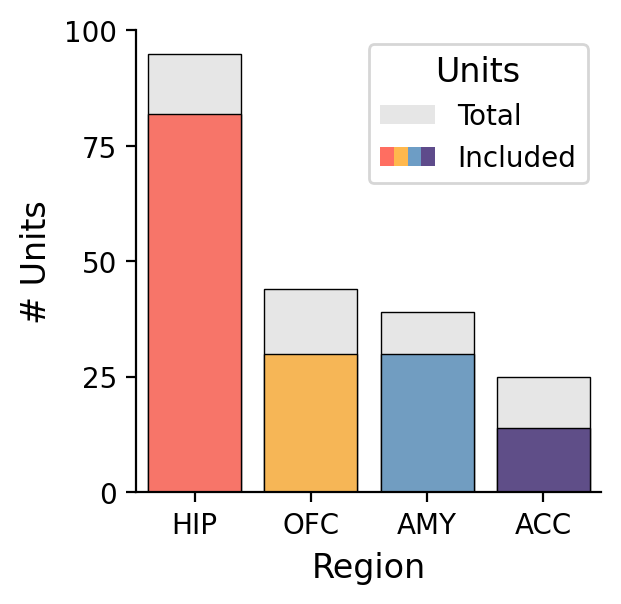

Valid Units: 156/203 (76.85) 

Region  Valid
HIP     True     82
AMY     True     30
OFC     True     30
ACC     True     14
OFC     False    14
HIP     False    13
ACC     False    11
AMY     False     9


In [24]:
fig, ax = plt.subplots(1, 1, figsize = (3, 3))
plotPal = regionPal
sns.countplot(x = 'Region', data = statsDF, order = plotOrder, color = '#e6e6e6')
sns.countplot(x = 'Region', data = statsDFValid, order = plotOrder, palette = plotPal, saturation = saturation)

# Figure aeshtetics
plt.setp(ax.patches, linewidth = 0.5, edgecolor = 'k')
cmaps = [ListedColormap('#e6e6e6'), ListedColormap(regionPal)]
cmap_handles = [Rectangle((0, 0), 1, 1) for _ in cmaps]
handler_map = dict(zip(cmap_handles, [HandlerColormap(cm, num_stripes = nRegions) for cm in cmaps]))
plt.legend(title = 'Units', labels = ['Total', 'Included'], handles = cmap_handles, handler_map = handler_map, title_fontsize = 'large', fontsize = 'medium', bbox_to_anchor = (1, 1))
ax.set_xlabel('Region', fontsize = 'large')
ax.set_ylabel('# Units', fontsize = 'large')
tick_spacing = 25
unitCap = int(np.ceil(statsDF['Region'].value_counts().max() / tick_spacing)) * tick_spacing
yticks = np.arange(0, unitCap + tick_spacing, tick_spacing)
ax.set_yticks(yticks)
ax.set_ylim(0, yticks[-1])
sns.despine(top = True, right = True)

# Export & Display
if export:
    plt.savefig((os.path.join(resultsDir, 'Group', 'Figures', 'ValidUnits.pdf')), dpi = 1200, bbox_inches = 'tight')
plt.show()

# Show counts
print('Valid Units: %i/%i (%.2f) \n' %(statsDFValid.shape[0], statsDF.shape[0], 100 * statsDFValid.shape[0] / statsDF.shape[0]))
print(statsDF.groupby('Region')['Valid'].value_counts().sort_values(ascending = False).to_string())

### 5.2 Laterality Analyses
Exported as: 
- `LateralitySummary.pdf`
- `LateralityRegion.pdf`
- `LateralityDistance.pdf`

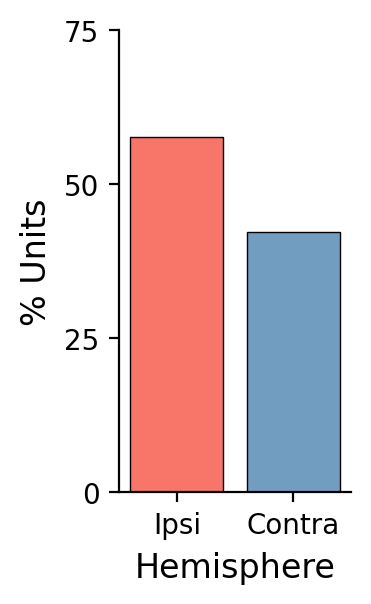

Total Units: 156 

Contralateral: 66 (42.31%)
Ipsilateral: 90 (57.69%)


In [25]:
fig, ax = plt.subplots(1, 1, figsize = (1.5, 3))
plotPal = altPairPal
sns.countplot(x = 'Ipsilateral', data = statsDFValid, palette = plotPal, order = latOrder, stat = 'percent', saturation = saturation)

# Figure aeshtetics
plt.setp(ax.patches, linewidth = 0.5, edgecolor = 'k')
ax.set_xlabel('Hemisphere', fontsize = 'large')
ax.set_ylabel('% Units', fontsize = 'large')
ax.set_xticklabels(['Ipsi', 'Contra'])
tick_spacing = 25
yticks = np.arange(0, 75 + 1, tick_spacing)
ax.set_yticks(yticks)
ax.set_ylim(0, yticks[-1])
sns.despine(top = True, right = True)

# Export & Display
if export:
    plt.savefig((os.path.join(resultsDir, 'Group', 'Figures', 'LateralitySummary.pdf')), dpi = 1200, bbox_inches = 'tight')
plt.show()

# Show counts
print('Total Units: %i \n' %statsDFValid.shape[0])
print('Contralateral: %i (%.2f%%)' %(statsDFValid[statsDFValid['Ipsilateral'] == False].shape[0], 100 * statsDFValid[statsDFValid['Ipsilateral'] == False].shape[0] / statsDFValid.shape[0]))
print('Ipsilateral: %i (%.2f%%)' %(statsDFValid[statsDFValid['Ipsilateral'] == True].shape[0], 100 * statsDFValid[statsDFValid['Ipsilateral'] == True].shape[0] / statsDFValid.shape[0]))

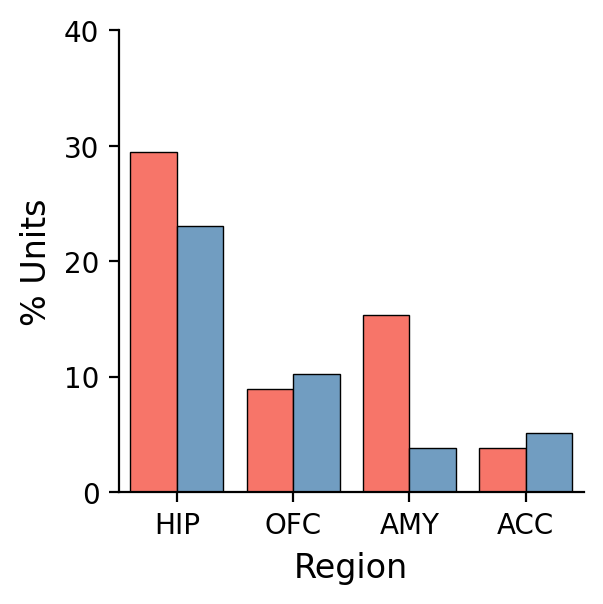

Total Units: 156 

Region  Ipsilateral
ACC     False           8
        True            6
AMY     True           24
        False           6
HIP     True           46
        False          36
OFC     False          16
        True           14


In [26]:
fig, ax = plt.subplots(1, 1, figsize = (3, 3))
plotPal = altPairPal
sns.countplot(x = 'Region', data = statsDFValid, order = plotOrder, hue = 'Ipsilateral', hue_order = latOrder, palette = plotPal, stat = 'percent', saturation = saturation)

# Figure aeshtetics
plt.setp(ax.patches, linewidth = 0.5, edgecolor = 'k')
handles = [Rectangle((0, 0), 1, 1, color = plotPal[0]), Rectangle((0, 0), 1, 1, color = plotPal[1])]
plt.legend(title = 'Hemisphere', handles = handles, labels = ['Ipsi', 'Contra'], loc = 'upper right', title_fontsize = 'small', fontsize = 'x-small', bbox_to_anchor = (1, 1))
ax.set_xlabel('Region', fontsize = 'large')
ax.set_ylabel('% Units', fontsize = 'large')
tick_spacing = 10
yticks = np.arange(0, 40 + 1, tick_spacing)
ax.set_yticks(yticks)
ax.set_ylim(0, yticks[-1])
sns.despine(top = True, right = True)

# Export & Display
if export:
    ax.get_legend().remove()
    plt.savefig((os.path.join(resultsDir, 'Group', 'Figures', 'LateralityRegion.pdf')), dpi = 1200, bbox_inches = 'tight')
plt.show()

# Show counts
print('Total Units: %i \n' %statsDFValid.shape[0])
print(statsDFValid.groupby('Region')['Ipsilateral'].value_counts().to_string())

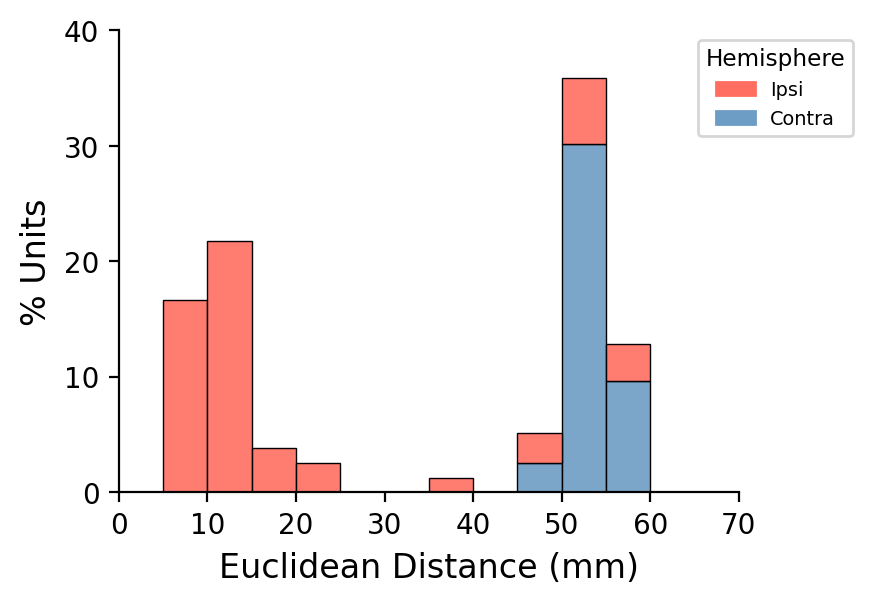

Distance Descriptives: 

             count  mean   std   min   25%   50%   75%   max
Ipsilateral                                                 
False        66.00 53.99  2.92 47.23 52.08 53.37 54.40 59.51
True         90.00 20.18 17.06  6.06  7.96 11.92 23.19 59.65


In [27]:
fig, ax = plt.subplots(1, 1, figsize = (4, 3))
plotPal = altPairPal

sns.histplot(x = 'EucDist', data = statsDFValid, hue = 'Ipsilateral', hue_order = [True, False], bins = np.arange(0, 70, 5), palette = plotPal, multiple = 'stack', stat = 'percent', linewidth = 0.5, legend = True, alpha = .9)

# Figure aeshtetics
plt.setp(ax.patches, linewidth = 0.5, edgecolor = 'k')
handles = [Rectangle((0, 0), 1, 1, color = plotPal[0]), Rectangle((0, 0), 1, 1, color = plotPal[1])]
plt.legend(title = 'Hemisphere', handles = handles, labels = ['Ipsi', 'Contra'], loc = 'upper right', title_fontsize = 'small', fontsize = 'x-small', bbox_to_anchor = (1.2, 1))
ax.set_xlabel('Euclidean Distance (mm)', fontsize = 'large')
ax.set_ylabel('% Units', fontsize = 'large')
yticks = np.arange(0, 40 + 1, 10)
ax.set_yticks(yticks)
ax.set_ylim(0, 40)
ax.set_xlim(0, 70)
sns.despine(top = True, right = True)

# Export & Display
if export:
    plt.savefig((os.path.join(resultsDir, 'Group', 'Figures', 'LateralityDistance.pdf')), dpi = 1200, bbox_inches = 'tight')
plt.show()

# Show descriptives
print('Distance Descriptives: \n')
print(statsDFValid.groupby('Ipsilateral')['EucDist'].describe().to_string())

### 5.3 Modulation Analyses
Exported as: 
- `ModulationSummary.pdf`
- `ModulationRegion.pdf`
- `ModulationPreFR.pdf`
- `*Venn.pdf`
- `FRScatterplots*.pdf`
- `FRChange*.pdf`

#### 5.3.1 Stim vs. No-Stim Proportions, Locations, & Characteristics

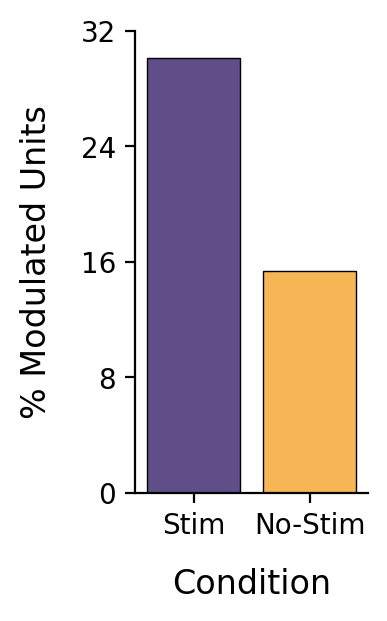

Total Units: 156 

Img Modulated: 62 (39.7%)
Stim Modulated: 47 (30.1%)
No-Stim Modulated: 24 (15.4%)
Odds Ratio (Stim/No-Stim): 2.37, p = 0.001


In [28]:
fig, ax = plt.subplots(1, 1, figsize = (1.5, 3), sharey = True)
plotPal = pairPal

# Parse data, convert to percentage
stim_cnt = 100 * statsDFValid['StimSig'].mean()
nostim_cnt = 100 * statsDFValid['NoStimSig'].mean()

# Create barplot
sns.barplot([stim_cnt, nostim_cnt], palette = plotPal, saturation = saturation)

# Figure aeshtetics
plt.setp(ax.patches, linewidth = 0.5, edgecolor = 'k')
ax.set_ylabel('% Modulated Units', fontsize = 'large', labelpad = 10)
tick_spacing = 8
yticks = np.arange(0, 32 + .1, tick_spacing)
ax.set_yticks(yticks)
ax.set_xticks([0, 1], ['Stim', 'No-Stim'])
ax.set_ylim(0, yticks[-1])
ax.set_xlabel('Condition', fontsize = 'large', labelpad = 10)
sns.despine(top = True, right = True)
# handles = [Rectangle((0, 0), 1, 1, color = plotPal[0]), Rectangle((0, 0), 1, 1, color = plotPal[1])]
# plt.legend(title = '$\Delta$ Firing Rate', handles = handles, labels = ['Mod (Stim)', 'Mod (No-Stim)'], title_fontsize = 'medium', fontsize = 'small', bbox_to_anchor = (0.8, 1))
# fig.suptitle('$\chi^2 (%i, %i)$: %.2f, $p$ = %.3f' %(dof, statsDFValid.shape[0], chi2, p), fontsize = 'small')
# fig.suptitle('$p$ = %.3f' %(p), fontsize = 'small')

# Export & Display
if export:
    plt.savefig((os.path.join(resultsDir, 'Group', 'Figures', 'ModulationSummary.pdf')), dpi = 1200, bbox_inches = 'tight')
plt.show()

# Show counts
print('Total Units: %i \n' %statsDFValid.shape[0])
print('Img Modulated: %i (%.1f%%)' %(statsDFValid['ImgSig'].sum(), 100 * statsDFValid['ImgSig'].mean()))
print('Stim Modulated: %i (%.1f%%)' %(statsDFValid['StimSig'].sum(), 100 * statsDFValid['StimSig'].mean()))
print('No-Stim Modulated: %i (%.1f%%)' %(statsDFValid['NoStimSig'].sum(), 100 * statsDFValid['NoStimSig'].mean()))


# Test for significance using fisher exact test
fisher_table = np.array([statsDFValid['StimSig'].value_counts(ascending = True).values, statsDFValid['NoStimSig'].value_counts(ascending = True).values])
odds, p = fisher_exact(fisher_table, alternative = 'greater')
print("Odds Ratio (Stim/No-Stim): %.2f, p = %.3f" %(odds, p))

In [29]:
print('Img Modulation:')
prop_img = statsDFValid['SigPerm_Img'].mean()
print('Onset: %.1f%%' %(100*prop_img))
print('')
print('Stim Modulation:')
prop_stim_during = statsDFValid['SigPerm_Stim_During'].mean()
prop_stim_post = statsDFValid['SigPerm_Stim_Post'].mean()
prop_stim_both = statsDFValid[['SigPerm_Stim_During', 'SigPerm_Stim_Post']].all(axis = 1).mean()
print('During: %.1f%%, Post: %.1f%%, Both: %.1f%%' %(100*prop_stim_during, 100*prop_stim_post, 100*prop_stim_both))
print('')
print('No-Stim Modulation:')
prop_nostim_during = statsDFValid['SigPerm_NoStim_During'].mean()
prop_nostim_post = statsDFValid['SigPerm_NoStim_Post'].mean()
prop_nostim_both = statsDFValid[['SigPerm_NoStim_During', 'SigPerm_NoStim_Post']].all(axis = 1).mean()
print('During: %.1f%%, Post: %.1f%%, Both: %.1f%%' %(100*prop_nostim_during, 100*prop_nostim_post, 100*prop_nostim_both))

Img Modulation:
Onset: 39.7%

Stim Modulation:
During: 25.0%, Post: 6.4%, Both: 1.3%

No-Stim Modulation:
During: 10.9%, Post: 5.8%, Both: 1.3%


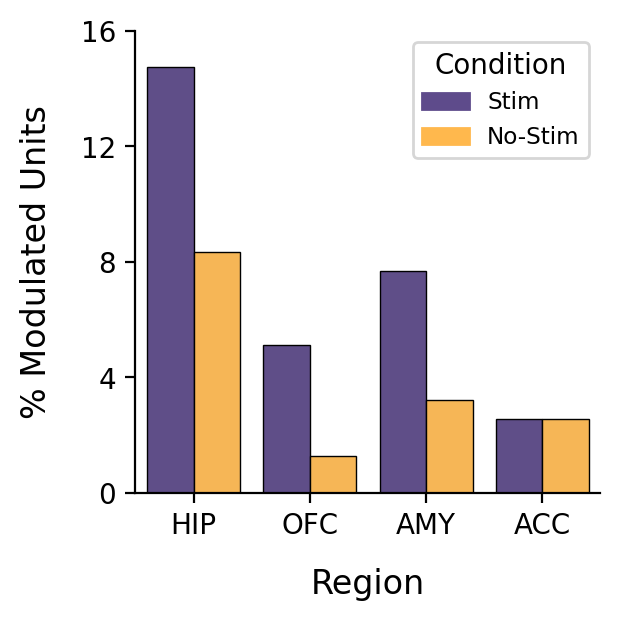

Total Units: 156 

        StimSig  NoStimSig
Region                    
ACC        2.56       2.56
AMY        7.69       3.21
HIP       14.74       8.33
OFC        5.13       1.28
HIP: Odds Ratio: 2.07, p = 0.044
OFC: Odds Ratio: 5.09, p = 0.040
AMY: Odds Ratio: 3.33, p = 0.042
ACC: Odds Ratio: 1.00, p = 0.661


In [30]:
fig, ax = plt.subplots(1, 1, figsize = (3, 3))
plotPal = pairPal

# Parse data
df_stim = statsDFValid[statsDFValid['StimSig'] == True]
df_nostim = statsDFValid[statsDFValid['NoStimSig'] == True]
stim_region_cnts = df_stim.groupby('Region')['StimSig'].value_counts()[['HIP', 'OFC', 'AMY', 'ACC']].values / statsDFValid.shape[0]
nostim_region_cnts = df_nostim.groupby('Region')['NoStimSig'].value_counts()[['HIP', 'OFC', 'AMY', 'ACC']].values / statsDFValid.shape[0]
plotDF = pd.DataFrame({'Region': ['HIP', 'OFC', 'AMY', 'ACC'], 'Stim': stim_region_cnts, 'No-Stim': nostim_region_cnts})
plotDF = plotDF.melt(id_vars = 'Region', var_name = 'Condition', value_name = 'Percent')
plotDF['Percent'] = 100 * plotDF['Percent']

sns.barplot(x = 'Region', y = 'Percent', data = plotDF, order = plotOrder, hue = 'Condition', palette = [plotPal[0], plotPal[1]], saturation = saturation, ax = ax)

# Figure aeshtetics
handles = [Rectangle((0, 0), 1, 1, color = plotPal[0]), Rectangle((0, 0), 1, 1, color = plotPal[1])]
plt.legend(title = 'Condition', handles = handles, labels = ['Stim', 'No-Stim'], title_fontsize = 'medium', fontsize = 'small', bbox_to_anchor = (1, 1))
plt.setp(ax.patches, linewidth = 0.5, edgecolor = 'k')
ax.set_ylabel('% Modulated Units', fontsize = 'large', labelpad = 10)
tick_spacing = 4
unitCap = 16
yticks = np.arange(0, unitCap + 1, tick_spacing)
ax.set_yticks(yticks)
ax.set_ylim(0, yticks[-1])
sns.despine(top = True, right = True)
ax.set_xlabel('Region', fontsize = 'large', labelpad = 10)
# fig.suptitle('$\chi^2 (%i, %i)$: %.2f, $p$ = %.3f' %(dof, statsDFValid.shape[0], chi2, p), fontsize = 'small')

# Export & Display
if export:
    plt.savefig((os.path.join(resultsDir, 'Group', 'Figures', 'ModulationRegion.pdf')), dpi = 1200, bbox_inches = 'tight')
plt.show()

# # Show counts
print('Total Units: %i \n' %statsDFValid.shape[0])
print(100 * statsDFValid.groupby(['Region'])[['StimSig', 'NoStimSig']].sum()/statsDFValid.shape[0])
    
# Test for significance using fisher's exact test
for region in statsDFValid['Region'].unique():
    region_df = statsDFValid[statsDFValid['Region'] == region]
    fisher_table = np.array([region_df['StimSig'].value_counts(ascending = True).values, region_df['NoStimSig'].value_counts(ascending = True).values])
    odds, p = fisher_exact(fisher_table, alternative = 'greater')
    print('%s: Odds Ratio: %.2f, p = %.3f' %(region, odds, p))

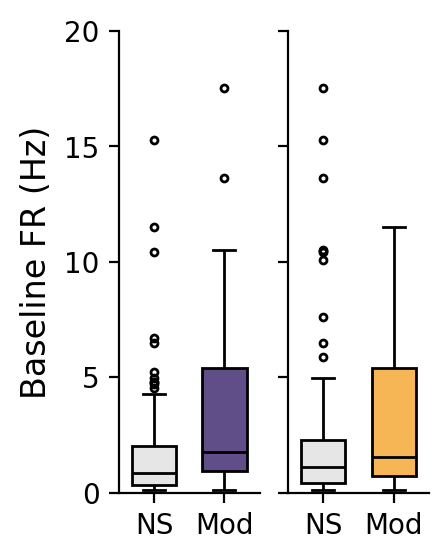

Stim Mod vs. NS Mod: U = 3450.50, p = 0.001
No-Stim Mod vs. NS Mod: U = 1964.00, p = 0.062
Stim Mod vs. No-Stim Mod: U = 593.00, p = 0.729

         count  mean  std  min  25%  50%  75%   max
StimSig                                            
False   109.00  1.70 2.35 0.10 0.33 0.86 1.99 15.28
True     47.00  4.19 6.12 0.11 0.95 1.77 5.39 35.66
           count  mean  std  min  25%  50%  75%   max
NoStimSig                                            
False     132.00  2.30 4.15 0.10 0.41 1.09 2.26 35.66
True       24.00  3.29 3.26 0.10 0.72 1.53 5.41 11.51


In [31]:
fig, ax = plt.subplots(1, 2, figsize = (2, 3), sharey = True)
plotPal = ['#e6e6e6', pairPal[0], pairPal[1]]

sns.boxplot(x = 'StimSig', y = 'FR_ISI', data = statsDFValid, palette = [plotPal[0], plotPal[1]], width = 0.5, linewidth = 1, linecolor = 'k', fliersize=2.5, gap = -0.25, saturation = saturation, ax = ax[0])
sns.boxplot(x = 'NoStimSig', y = 'FR_ISI', data = statsDFValid, palette = [plotPal[0], plotPal[2]], width = 0.5, linewidth = 1, linecolor = 'k', fliersize=2.5, gap = -0.25, saturation = saturation, ax = ax[1])

# Figure aeshtetics
for axis in ax:
    plt.setp(axis.patches, linewidth = 1, edgecolor = 'k')
    axis.set_xlabel('')
    axis.set_ylabel('Baseline FR (Hz)', fontsize = 'large')
    axis.set_xticklabels(['NS', 'Mod'])
    tick_spacing = 5
    unitCap = int(np.ceil(statsDFValid['FR_ISI'].max() / tick_spacing) * tick_spacing)
    yticks = np.arange(0, unitCap + tick_spacing, tick_spacing)
    axis.set_yticks(yticks)
    axis.set_ylim(0, 20)
sns.despine(top = True, right = True)
# ax[0].set_xlabel('Image\n+ Stim', fontsize = 'large', labelpad = 10)
# ax[1].set_xlabel('Image', fontsize = 'large', labelpad = 10)
# Add the coefficient, z-value, SE, and p-value to the plot
# plt.suptitle('Mod: $z$ = %.2f, $p$ = %.3f\nCondition: $z$ = %.2f, $p$ = %.3f\nMod$\\times$Condition: $z$ = %.2f, $p$ = %.3f' %(model.tvalues['Sig[T.True]'], model.pvalues['Sig[T.True]'], model.tvalues['Condition[T.Stim]'], model.pvalues['Condition[T.Stim]'], model.tvalues['Sig[T.True]:Condition[T.Stim]'], model.pvalues['Sig[T.True]:Condition[T.Stim]']), fontsize = 'small', y = 1.075)

# Export & Display
if export:
    plt.savefig((os.path.join(resultsDir, 'Group', 'Figures', 'ModulationPreFR.pdf')), dpi = 1200, bbox_inches = 'tight')
plt.show()

# Mann Whitney U test
mwu1 = mannwhitneyu(statsDFValid[statsDFValid['StimSig'] == True]['FR_ISI'], statsDFValid[statsDFValid['StimSig'] == False]['FR_ISI'])
mwu2 = mannwhitneyu(statsDFValid[statsDFValid['NoStimSig'] == True]['FR_ISI'], statsDFValid[statsDFValid['NoStimSig'] == False]['FR_ISI'])
mwu1x2 = mannwhitneyu(statsDFValid[statsDFValid['StimSig'] == True]['FR_ISI'], statsDFValid[statsDFValid['NoStimSig'] == True]['FR_ISI'])
print('Stim Mod vs. NS Mod: U = %.2f, p = %.3f' %(mwu1[0], mwu1[1]))
print('No-Stim Mod vs. NS Mod: U = %.2f, p = %.3f' %(mwu2[0], mwu2[1]))
print('Stim Mod vs. No-Stim Mod: U = %.2f, p = %.3f' %(mwu1x2[0], mwu1x2[1]))
print()

# Show descriptives
print(statsDFValid.groupby(['StimSig'])['FR_ISI'].describe())
print(statsDFValid.groupby(['NoStimSig'])['FR_ISI'].describe())

#### 5.3.2 Modulation Venn Diagrams

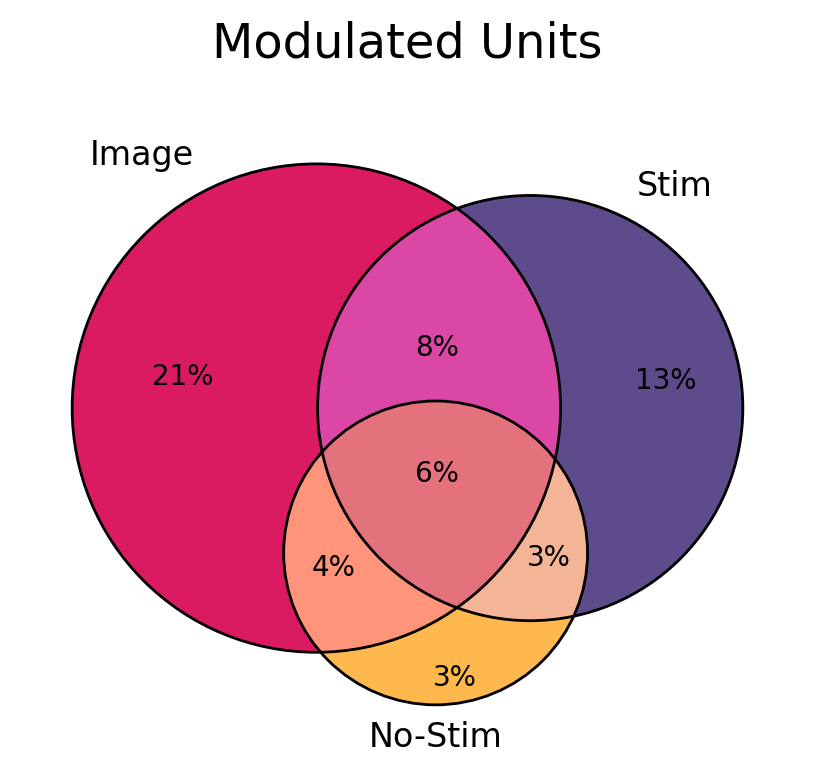

In [32]:
# Create venn diagram for units that are modulated across all contrasts
fig, ax = plt.subplots(1, 1, figsize = (5, 5))
plotPal = [validPal[0], pairPal[0], pairPal[1]]
venn_table = statsDFValid.copy()
venn_table['ID'] = venn_table['pID'] + '_' + venn_table['Unit']
set1 = set(venn_table[venn_table['ImgSig'] == True]['ID'])
set2 = set(venn_table[venn_table['StimSig'] == True]['ID'])
set3 = set(venn_table[venn_table['NoStimSig'] == True]['ID'])
v = venn3([set1, set2, set3], set_labels = ['Image', 'Stim', 'No-Stim'], set_colors = plotPal, ax = ax, subset_label_formatter=lambda x: f"{x / len(statsDFValid) * 100:.0f}%", alpha = 1)

c = venn3_circles([set1, set2, set3], linewidth=1, color='k')
plt.title('Modulated Units', fontsize = 'xx-large', pad = 20)

# Export & Display
if export:
    plt.savefig((os.path.join(resultsDir, 'Group', 'Figures', 'AllVenn.pdf')), dpi = 1200, bbox_inches = 'tight')
plt.show()

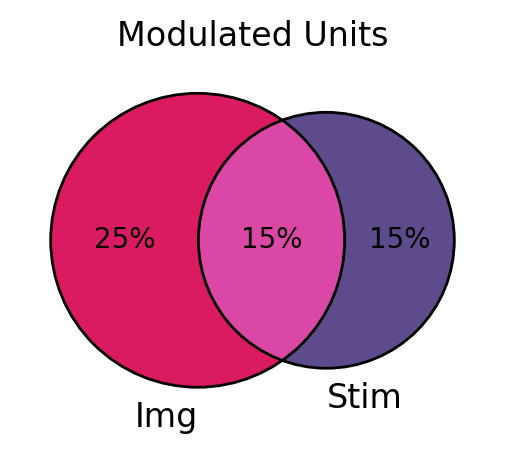

In [33]:
# Create venn diagram for units that are modulated during Img and Stim conditions
fig, ax = plt.subplots(1, 1, figsize = (3, 3))
plotPal = [validPal[0], pairPal[0]]
venn_table = statsDFValid.copy()
venn_table['ID'] = venn_table['pID'] + '_' + venn_table['Unit']
set1 = set(venn_table[venn_table['ImgSig'] == True]['ID'])
set2 = set(venn_table[venn_table['StimSig'] == True]['ID'])
v = venn2([set1, set2], set_labels = ['Img', 'Stim'], set_colors = plotPal, ax = ax, subset_label_formatter=lambda x: f"{x / len(statsDFValid) * 100:.0f}%", alpha = 1)

c = venn2_circles([set1, set2], linewidth=1, color='k')
plt.title('Modulated Units', fontsize = 'large')

# Export & Display
if export:
    plt.savefig((os.path.join(resultsDir, 'Group', 'Figures', 'ImgStimVenn.pdf')), dpi = 1200, bbox_inches = 'tight')
plt.show()

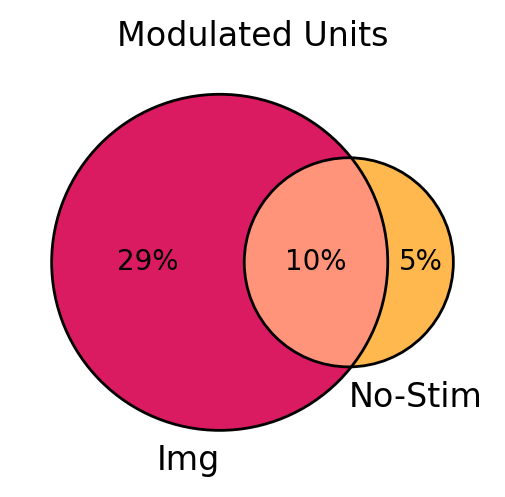

In [34]:
# Create venn diagram for units that are modulated during Img and No-Stim conditions
fig, ax = plt.subplots(1, 1, figsize = (3, 3))
plotPal = [validPal[0], pairPal[1]]
venn_table = statsDFValid.copy()
venn_table['ID'] = venn_table['pID'] + '_' + venn_table['Unit']
set1 = set(venn_table[venn_table['ImgSig'] == True]['ID'])
set2 = set(venn_table[venn_table['NoStimSig'] == True]['ID'])
v = venn2([set1, set2], set_labels = ['Img', 'No-Stim'], set_colors = plotPal, ax = ax, subset_label_formatter=lambda x: f"{x / len(statsDFValid) * 100:.0f}%", alpha = 1)

c = venn2_circles([set1, set2], linewidth=1, color='k')
plt.title('Modulated Units', fontsize = 'large')

# Export & Display
if export:
    plt.savefig((os.path.join(resultsDir, 'Group', 'Figures', 'ImgNoStimVenn.pdf')), dpi = 1200, bbox_inches = 'tight')
plt.show()

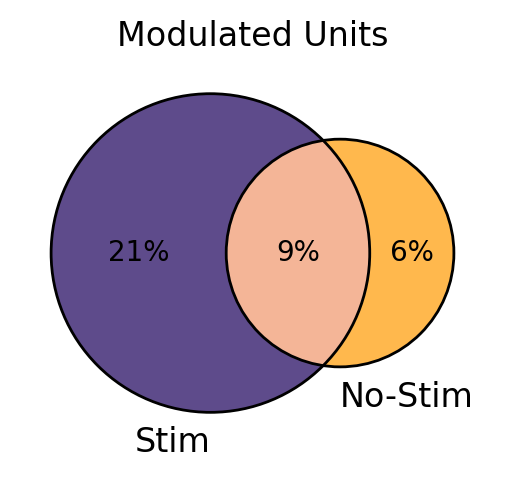

In [35]:
# Create venn diagram for units that are modulated during Stim and No-Stim conditions
fig, ax = plt.subplots(1, 1, figsize = (3, 3))
plotPal = pairPal
venn_table = statsDFValid.copy()
venn_table['ID'] = venn_table['pID'] + '_' + venn_table['Unit']
set1 = set(venn_table[venn_table['StimSig'] == True]['ID'])
set2 = set(venn_table[venn_table['NoStimSig'] == True]['ID'])
v = venn2([set1, set2], set_labels = ['Stim', 'No-Stim'], set_colors = plotPal, ax = ax, subset_label_formatter=lambda x: f"{x / len(statsDFValid) * 100:.0f}%", alpha = 1)

c = venn2_circles([set1, set2], linewidth=1, color='k')
plt.title('Modulated Units', fontsize = 'large')

# Export & Display
if export:
    plt.savefig((os.path.join(resultsDir, 'Group', 'Figures', 'StimNoStimVenn.pdf')), dpi = 1200, bbox_inches = 'tight')
plt.show()

#### 5.3.3 Characterization of FR Modulation

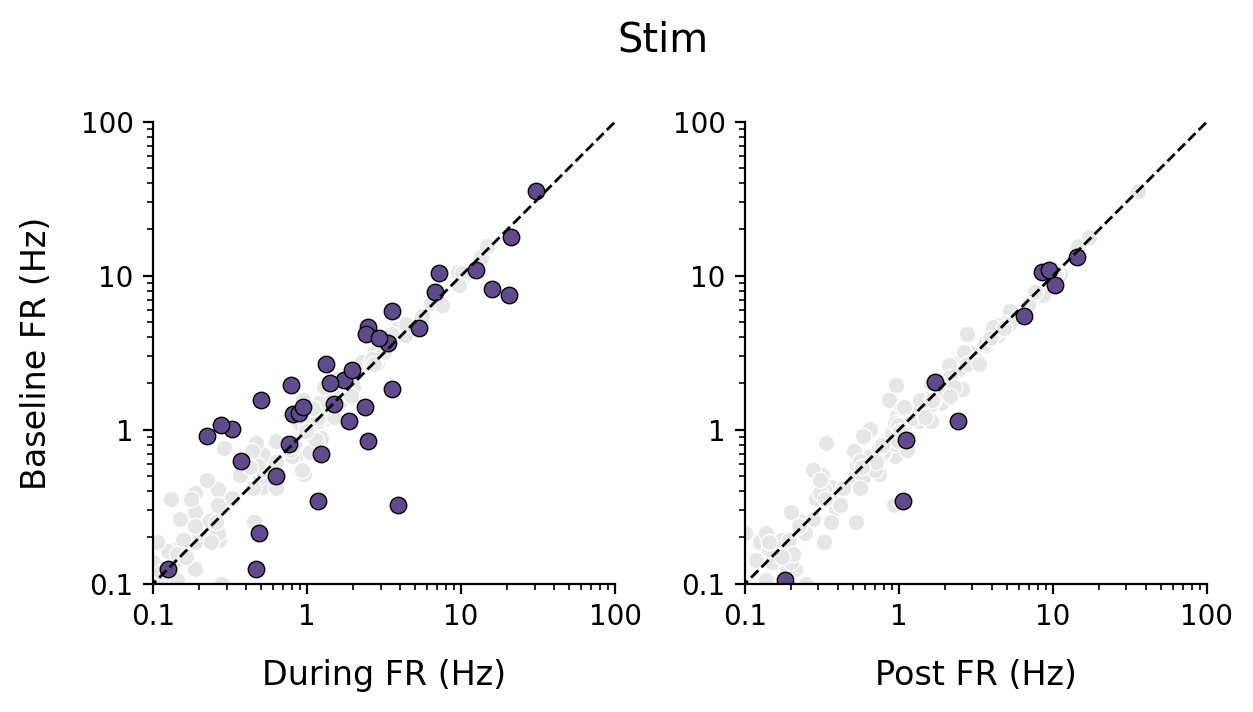

In [36]:
fig, axes = plt.subplots(1, 2, figsize = (7, 3), sharex=True)
plotPal = ['#e6e6e6', pairPal[0]]

df_stimns_during = statsDFValid[statsDFValid['SigPerm_Stim_During'] == False]
df_stimns_post = statsDFValid[statsDFValid['SigPerm_Stim_Post'] == False]
df_stimsig_during = statsDFValid[statsDFValid['SigPerm_Stim_During'] == True]
df_stimsig_post = statsDFValid[statsDFValid['SigPerm_Stim_Post'] == True]

# Params
s = 35

# Plot non-modulated units
sns.scatterplot(data = df_stimns_during, x = 'FR_Stim_During', y = 'FR_Stim_ISI', s = s, alpha = 1, ax = axes[0], color = plotPal[0], edgecolor = 'white')
sns.scatterplot(data = df_stimns_post, x = 'FR_Stim_Post', y = 'FR_Stim_ISI', s = s, alpha = 1, ax = axes[1], color = plotPal[0], edgecolor = 'white')

# Plot modulated units
sns.scatterplot(data = df_stimsig_during, x = 'FR_Stim_During', y = 'FR_Stim_ISI', s = s, alpha = 1, ax = axes[0], color = plotPal[1], edgecolor = 'k', lw = 0.5)
sns.scatterplot(data = df_stimsig_post, x = 'FR_Stim_Post', y = 'FR_Stim_ISI', s = s, alpha = 1, ax = axes[1], color = plotPal[1], edgecolor = 'k', lw = 0.5)

for ax in axes:
    # draw line on diagonal
    ax.plot([0, 100], [0, 100], color = 'k', linestyle = '--', linewidth = 1)
    ax.set_ylabel('Baseline FR (Hz)', fontsize = 'large', labelpad = 10)
    if ax == axes[1]:
        ax.set_ylabel(' ', fontsize = 'large', labelpad = 10)
    sns.despine(top = True, right = True)
    ax.set_aspect('equal', 'box')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(0.1, 100)
    ax.set_ylim(0.1, 100)
    ax.set_xticks([0.1, 1, 10, 100], ['0.1', '1', '10', '100'], fontsize = 'medium')
    ax.set_yticks([0.1, 1, 10, 100], ['0.1', '1', '10', '100'], fontsize = 'medium')
    
    # ax.legend().remove()

plt.suptitle('Stim', fontsize = 'x-large', y = 1.05)
axes[0].set_xlabel('During FR (Hz)', fontsize = 'large', labelpad = 10)
axes[1].set_xlabel('Post FR (Hz)', fontsize = 'large', labelpad = 10)

# Export & Display
if export:
    plt.savefig((os.path.join(resultsDir, 'Group', 'Figures', 'FRScatterplotsStim.pdf')), dpi = 1200, bbox_inches = 'tight')
plt.show()

In [37]:
print('Stim-During: %.1f%%' %(100 * statsDFValid['SigPerm_Stim_During'].mean()))
print('Stim-Post: %.1f%%' %(100 * statsDFValid['SigPerm_Stim_Post'].mean()))
print('Stim-Both: %.1f%%' %(100 * statsDFValid[['SigPerm_Stim_During', 'SigPerm_Stim_Post']].all(axis = 1).mean()))

Stim-During: 25.0%
Stim-Post: 6.4%
Stim-Both: 1.3%


In [38]:
print('Stim-Modulated Units:')
print('During - ISI Descriptives:')
df = statsDFValid[statsDFValid['SigPerm_Stim_During'] == True]
print('Suppression: %.1f%%' %(100*(df['Stim_During_Z'] < 0).mean()))
print('Enhancement: %.1f%%' %(100*(df['Stim_During_Z'] > 0).mean()))
print((df['Stim_During_Z']).abs().describe())
print('')
df = statsDFValid[statsDFValid['SigPerm_Stim_Post'] == True]
print('Suppression: %.1f%%' %(100*(df['Stim_Post_Z'] < 0).mean()))
print('Enhancement: %.1f%%' %(100*(df['Stim_Post_Z'] > 0).mean()))
print((df['Stim_Post_Z']).abs().describe())

Stim-Modulated Units:
During - ISI Descriptives:
Suppression: 56.4%
Enhancement: 43.6%
count   39.00
mean     0.60
std      0.58
min      0.00
25%      0.32
50%      0.43
75%      0.64
max      2.91
Name: Stim_During_Z, dtype: float64

Suppression: 30.0%
Enhancement: 70.0%
count   10.00
mean     0.43
std      0.27
min      0.23
25%      0.25
50%      0.32
75%      0.43
max      0.94
Name: Stim_Post_Z, dtype: float64


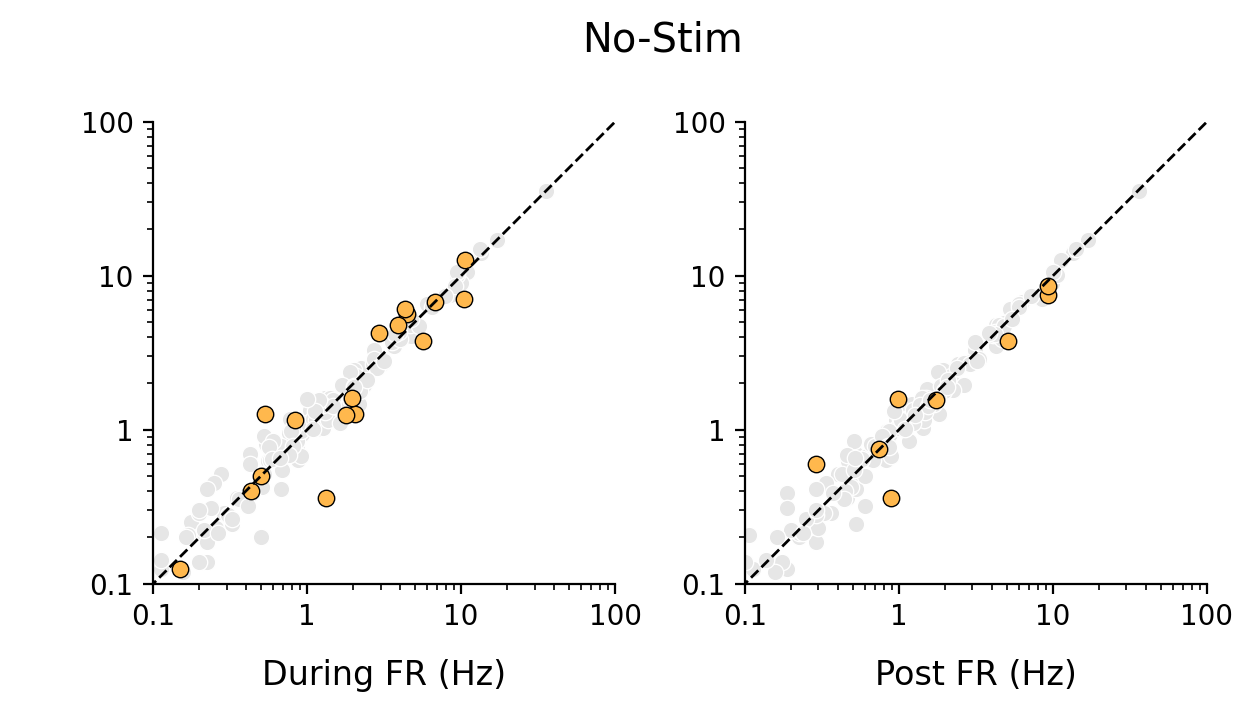

In [39]:
fig, axes = plt.subplots(1, 2, figsize = (7, 3), sharex=True)
plotPal = ['#e6e6e6', pairPal[1]]

df_nostimns_during = statsDFValid[statsDFValid['SigPerm_NoStim_During'] == False]
df_nostimns_post = statsDFValid[statsDFValid['SigPerm_NoStim_Post'] == False]
df_nostimsig_during = statsDFValid[statsDFValid['SigPerm_NoStim_During'] == True]
df_nostimsig_post = statsDFValid[statsDFValid['SigPerm_NoStim_Post'] == True]

# Params
s = 35

# Plot non-modulated units
sns.scatterplot(data = df_nostimns_during, x = 'FR_NoStim_During', y = 'FR_NoStim_ISI', s = s, alpha = 1, ax = axes[0], color = plotPal[0], edgecolor = 'white')
sns.scatterplot(data = df_nostimns_post, x = 'FR_NoStim_Post', y = 'FR_NoStim_ISI', s = s, alpha = 1, ax = axes[1], color = plotPal[0], edgecolor = 'white')

# Plot modulated units
sns.scatterplot(data = df_nostimsig_during, x = 'FR_NoStim_During', y = 'FR_NoStim_ISI', s = s, alpha = 1, ax = axes[0], color = plotPal[1], edgecolor = 'k', lw = 0.5)
sns.scatterplot(data = df_nostimsig_post, x = 'FR_NoStim_Post', y = 'FR_NoStim_ISI', s = s, alpha = 1, ax = axes[1], color = plotPal[1], edgecolor = 'k', lw = 0.5)

for ax in axes:
    # draw line on diagonal
    ax.plot([0, 100], [0, 100], color = 'k', linestyle = '--', linewidth = 1)
    ax.set_ylabel(' ', fontsize = 'large', labelpad = 10)
    sns.despine(top = True, right = True)
    ax.set_aspect('equal', 'box')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(0.1, 100)
    ax.set_ylim(0.1, 100)
    ax.set_xticks([0.1, 1, 10, 100], ['0.1', '1', '10', '100'], fontsize = 'medium')
    ax.set_yticks([0.1, 1, 10, 100], ['0.1', '1', '10', '100'], fontsize = 'medium')
    
    # ax.legend().remove()
plt.suptitle('No-Stim', fontsize = 'x-large', y = 1.05)
axes[0].set_xlabel('During FR (Hz)', fontsize = 'large', labelpad = 10)
axes[1].set_xlabel('Post FR (Hz)', fontsize = 'large', labelpad = 10)

# Export & Display
if export:
    plt.savefig((os.path.join(resultsDir, 'Group', 'Figures', 'FRScatterplotsNoStim.pdf')), dpi = 1200, bbox_inches = 'tight')
plt.show()

In [40]:
print('NoStim-During: %.1f%%' %(100 * statsDFValid['SigPerm_NoStim_During'].mean()))
print('NoStim-Post: %.1f%%' %(100 * statsDFValid['SigPerm_NoStim_Post'].mean()))
print('NoStim-Both: %.1f%%' %(100 * statsDFValid[['SigPerm_NoStim_During', 'SigPerm_NoStim_Post']].all(axis = 1).mean()))

NoStim-During: 10.9%
NoStim-Post: 5.8%
NoStim-Both: 1.3%


In [41]:
print('NoStim-Modulated Units:')
print('During - ISI Descriptives:')
df = statsDFValid[statsDFValid['SigPerm_NoStim_During'] == True]
print('Suppression: %.1f%%' %(100*(df['NoStim_During_Z'] < 0).mean()))
print('Enhancement: %.1f%%' %(100*(df['NoStim_During_Z'] > 0).mean()))
print((df['NoStim_During_Z']).abs().describe())
print('')
df = statsDFValid[statsDFValid['SigPerm_NoStim_Post'] == True]
print('Suppression: %.1f%%' %(100*(df['NoStim_Post_Z'] < 0).mean()))
print('Enhancement: %.1f%%' %(100*(df['NoStim_Post_Z'] > 0).mean()))
print((df['NoStim_Post_Z']).abs().describe())

NoStim-Modulated Units:
During - ISI Descriptives:
Suppression: 41.2%
Enhancement: 58.8%
count   17.00
mean     0.38
std      0.24
min      0.00
25%      0.17
50%      0.43
75%      0.51
max      0.74
Name: NoStim_During_Z, dtype: float64

Suppression: 33.3%
Enhancement: 66.7%
count   9.00
mean    0.30
std     0.18
min     0.01
25%     0.14
50%     0.37
75%     0.41
max     0.53
Name: NoStim_Post_Z, dtype: float64


### 5.3.4 Modulation by Distance to Stim

In [42]:
statsDFValid

,pID,Unit,Region,Ipsilateral,Valid,FR_ISI,FR_Stim_ISI,FR_NoStim_ISI,FR_Img,FR_Stim_During,...,MNI_X,MNI_Y,MNI_Z,EucDist,Stim_Img_Z,Stim_During_Z,Stim_Post_Z,NoStim_Img_Z,NoStim_During_Z,NoStim_Post_Z
0,BJH02702,mLHIP1-1,HIP,False,True,3.53,3.54,3.52,5.87,2.86,...,-22.48,-22.32,-16.56,54.40,0.44,-0.21,0.05,0.94,0.04,0.22
1,BJH02702,mLHIP4-2,HIP,False,True,0.81,0.68,0.95,1.11,0.84,...,-22.48,-22.32,-16.56,54.40,0.38,0.16,0.26,0.20,-0.17,-0.07
3,BJH02702,mLHIP5-1,HIP,False,True,4.13,4.11,4.15,4.44,4.30,...,-22.48,-22.32,-16.56,54.40,0.18,0.08,0.13,0.08,0.07,-0.02
4,BJH02702,mLHIP5-2,HIP,False,True,0.44,0.36,0.51,0.31,0.33,...,-22.48,-22.32,-16.56,54.40,-0.08,-0.06,-0.02,-0.27,-0.30,-0.14
5,BJH02702,mLHIP6-1,HIP,False,True,5.22,4.81,5.62,6.05,4.94,...,-22.48,-22.32,-16.56,54.40,0.63,0.06,0.10,0.15,-0.51,-0.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,UIC20230801,mRHIP7-1,HIP,True,True,0.99,0.97,1.01,1.00,0.98,...,18.96,-11.24,-19.38,13.17,0.08,0.01,0.04,-0.06,0.07,0.08
199,UIC20230801,mLACC7-1,ACC,False,True,1.50,1.40,1.59,1.36,0.94,...,-5.36,34.05,9.84,59.51,-0.12,-0.34,-0.24,-0.08,-0.37,-0.37
200,UIC20230801,mLACC7-2,ACC,False,True,0.62,0.57,0.66,1.10,0.42,...,-5.36,34.05,9.84,59.51,0.52,-0.18,0.00,0.55,0.01,-0.14
201,UIC20230801,mRHIP5-1,HIP,True,True,0.13,0.12,0.14,0.16,0.11,...,18.96,-11.24,-19.38,13.17,0.08,-0.02,-0.08,0.05,-0.08,-0.02


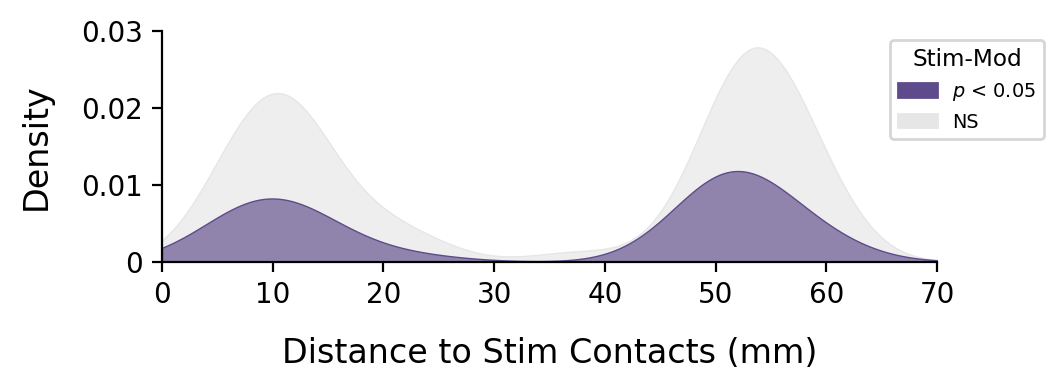

In [97]:
fig, ax = plt.subplots(figsize=(5, 1.5))
plotPal = [pairPal[0], '#e6e6e6']

sns.kdeplot(x = 'EucDist', data = statsDFValid, hue = 'StimSig', hue_order = [True, False], linewidth = 0.5, legend = True, alpha = .65, fill = True, palette = plotPal, clip = (0, 70), bw_adjust = 0.5, ax = ax)

# Figure aeshtetics
plt.setp(ax.patches, linewidth = 0.5, edgecolor = 'k')
handles = [Rectangle((0, 0), 1, 1, color = plotPal[0]), Rectangle((0, 0), 1, 1, color = plotPal[1])]
plt.legend(title = 'Stim-Mod', handles = handles, labels = ['$p$ < 0.05', 'NS'], loc = 'upper right', title_fontsize = 'small', fontsize = 'x-small', bbox_to_anchor = (1.15, 1))
ax.set_xlabel('Distance to Stim Contacts (mm)', fontsize = 'large', labelpad= 10)
ax.set_ylabel('Density', fontsize = 'large', labelpad = 10)
ax.set_yticks([0, 0.01, 0.02, 0.03], ['0', '0.01', '0.02', '0.03'], fontsize = 'medium')
ax.set_xlim(0, 70)
sns.despine(top = True, right = True)

# Export & Display
if export:
    plt.savefig((os.path.join(resultsDir, 'Group', 'Figures', 'ModDistance.pdf')), dpi = 1200, bbox_inches = 'tight')
plt.show()

# Show descriptives
# print('Distance Descriptives: \n')
# print(statsDFValid.groupby('Ipsilateral')['EucDist'].describe().to_string())